# Audio source separation

Requires `scipy==1.10.1` and `mdct==0.4`. 

Execute the next cell to install these libraries then restart the kernel.

In [1]:
!pip install scipy==1.10.1 mdct==0.4


[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: python3.10 -m pip install --upgrade pip


In [2]:
# imports
import matplotlib.pyplot as plt
import numpy as np
import scipy.io.wavfile as wavfile
from scipy.signal import hamming
from scipy.spatial.distance import cdist

import IPython.display as ipd
from mdct.fast import mdct, imdct
from scipy.io.wavfile import write

plt.rcParams['figure.figsize'] = (12,8)

In [3]:
# useful functions

def plot_sound(data, rate, title=None):
    if data.ndim == 1:
        data = data[:,np.newaxis]
    times = np.arange(data.shape[0])/rate
    plt.figure(figsize=(30,6))
    for channel in data.T:
        plt.fill_between(times, channel)
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.xlim(times[0], times[-1])
    if title:
        plt.title(title)
    plt.show()
    
def play_sound(data, rate):
    return ipd.display(ipd.Audio(data.T, rate=rate))

T = 220501, M = 2


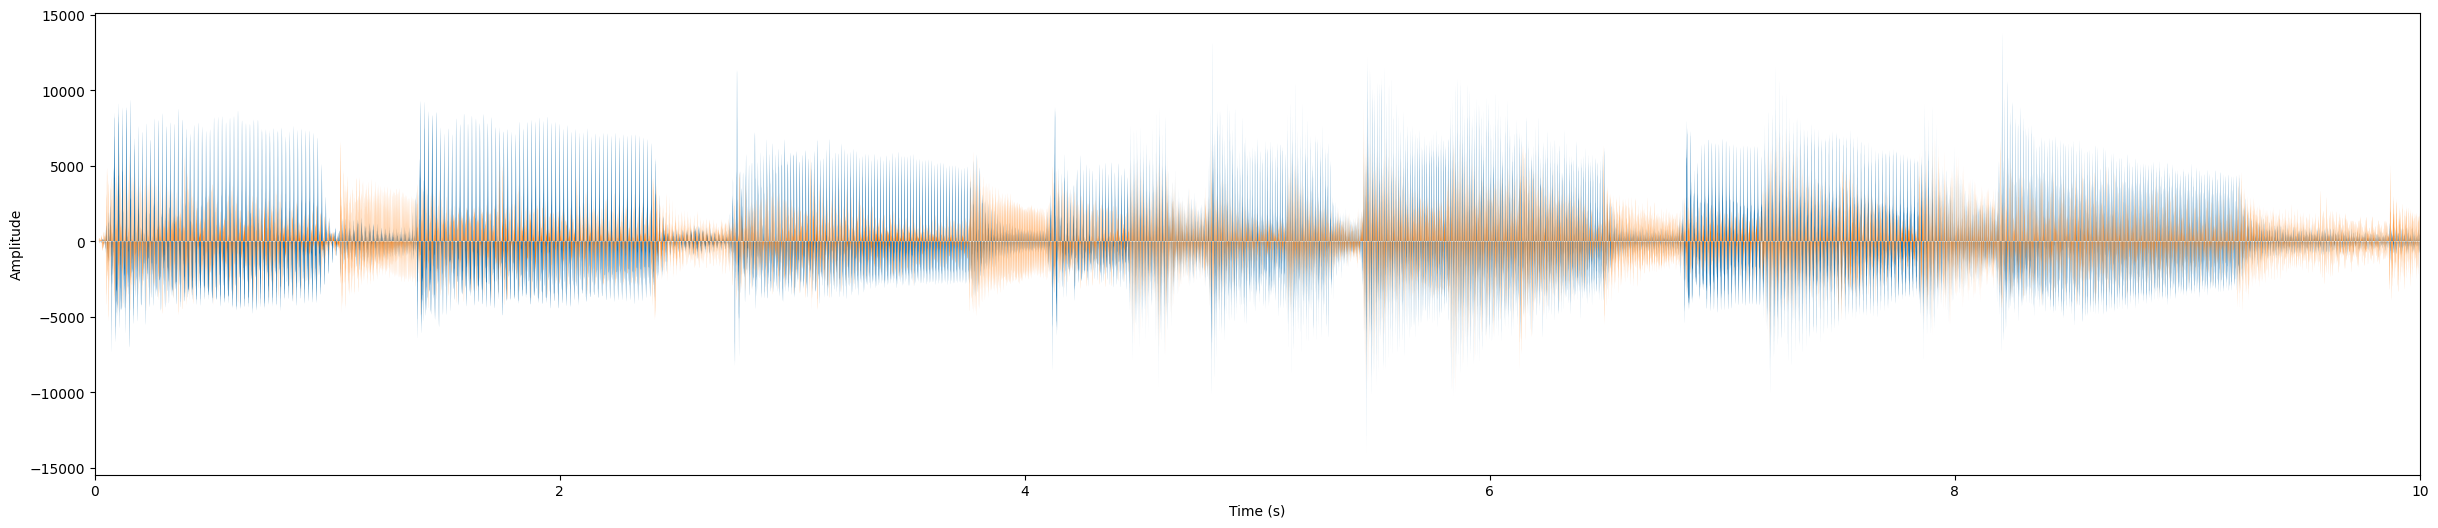

In [4]:
fname = 'mix.wav'

rate, x = wavfile.read(fname)
print('T = {:d}, M = {:d}'.format(*x.shape))
plot_sound(x, rate)
play_sound(x, rate)

In [5]:
write('new_mix.wav', rate, np.array(x, dtype=np.int16)) # to write a new wave file

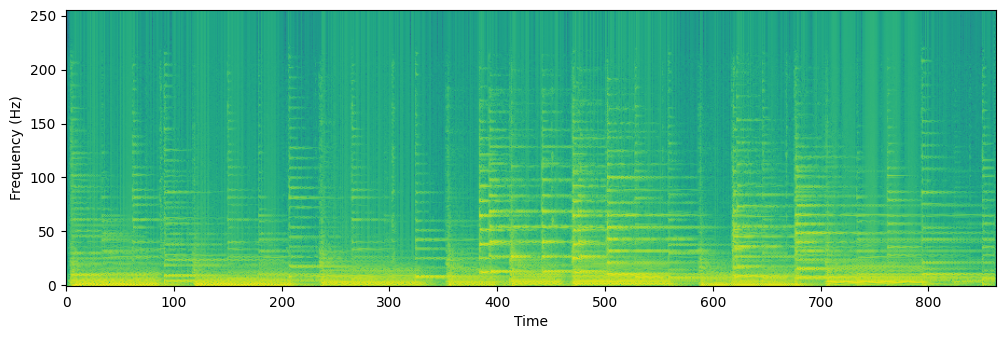

In [6]:
X = mdct(x, window=hamming, framelength=512)
Z = X.view(dtype=np.complex128)[...,0]

X_norm = np.abs(Z)**2

plt.imshow(np.log(X_norm+1e-10), origin='lower')
plt.xlabel('Time')
plt.ylabel('Frequency (Hz)')
plt.show()

1. Open ﬁle mix.wav and load it in a T × M matrix x(t, m), where M = 2 and T is the number of samples. Use your headphones to listen to the mixture. What is the number K of instruments that you can hear? From which direction do you perceive them?

T = 220501, M = 2


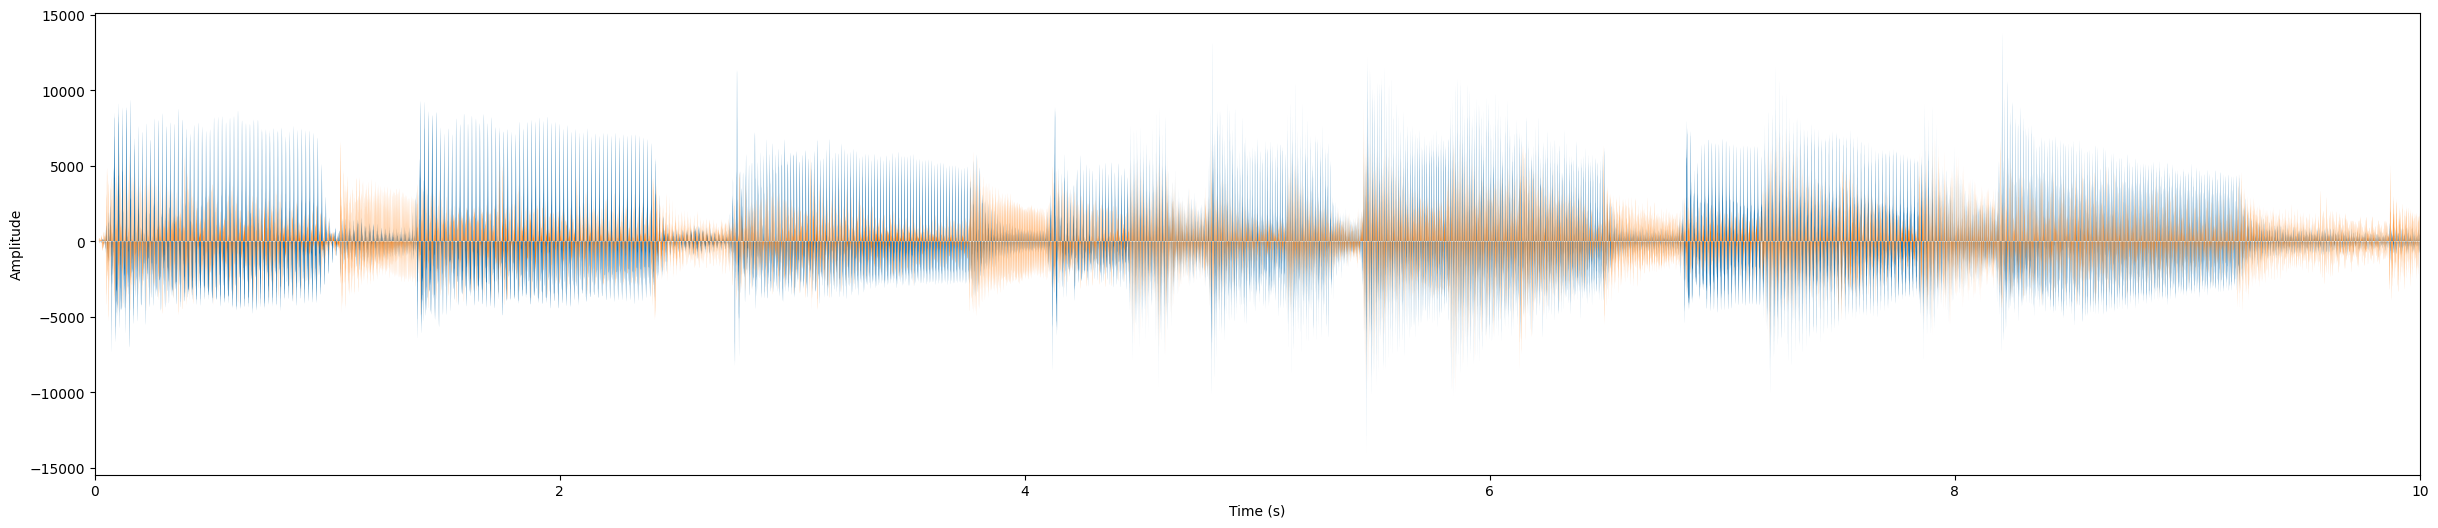

In [7]:
fname = 'mix.wav'

rate, x = wavfile.read(fname)
print('T = {:d}, M = {:d}'.format(*x.shape))
plot_sound(x, rate)
play_sound(x, rate)

k = 3
two directions

2. Plot the temporal dispersion diagram, deﬁned as the set of points in the plane of coordinates (x(t, 1), x(t, 2)) for all t (in order to plot a set of points, you can use the Matlab function plot or the Python function matplotlib.pyplot.plot with parameter ’x’, and you can normalize the axes with the Matlab instruction axis equal or the Python Matplotlib function axis(’equal’)). Can you distinguish the directions of the sources?

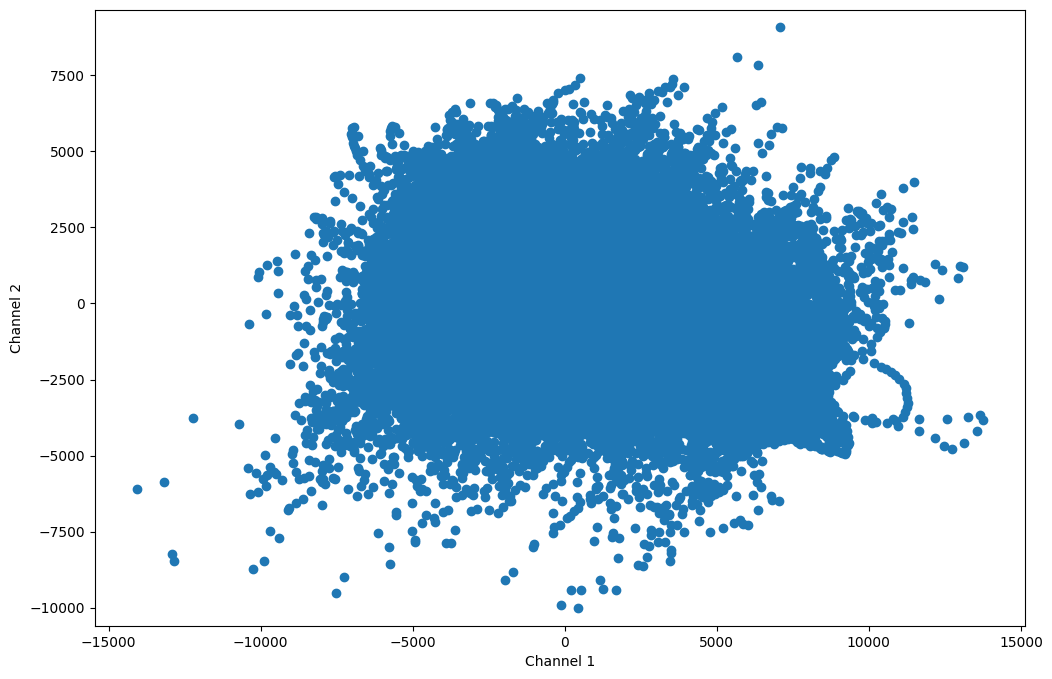

In [8]:
fig = plt.figure(figsize=(12,8))
plt.scatter(x[:,0],x[:,1])
plt.axis('equal')
plt.xlabel('Channel 1')
plt.ylabel('Channel 2')
plt.show()

Cannot distinguish the directions.

3. Compute the MDCT X(f, n, m) of the two stereophonic channels x(t, m) (you can use the Matlab function wmdct, with F = 512 frequency bands and the window ’sqrthann’, or the Python function mdct). Plot the corresponding time-frequency representations |X(f, n, m)| 2 (you can use the Matlab function plotwmdct or the Python function matplotlib.pyplot.imshow).

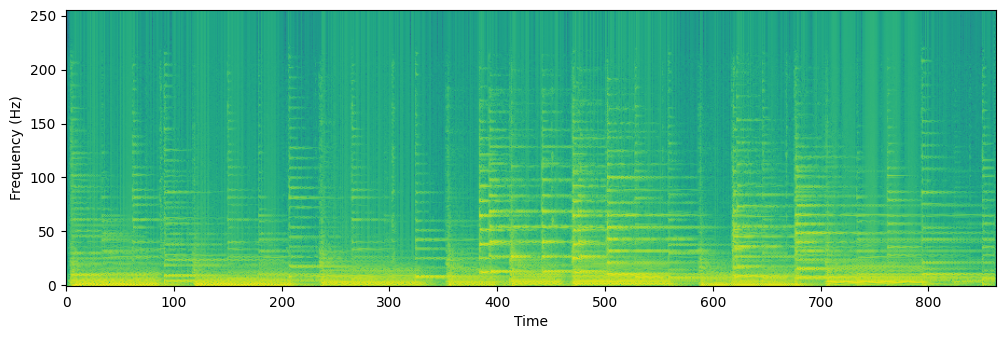

In [9]:
X = mdct(x, window=hamming, framelength=512)
Z = X.view(dtype=np.complex128)[...,0]

X_norm = np.abs(Z)**2

fig = plt.figure(figsize=(12,8))
plt.imshow(np.log(X_norm+1e-10), origin='lower')
plt.xlabel('Time')
plt.ylabel('Frequency (Hz)')
plt.show()

4. Plot the time-frequency dispersion diagram, deﬁned as the set of points in the plane of aﬃx Z(f, n) for all f and n. Can you distinguish the directions of the sources? How do you explain it?

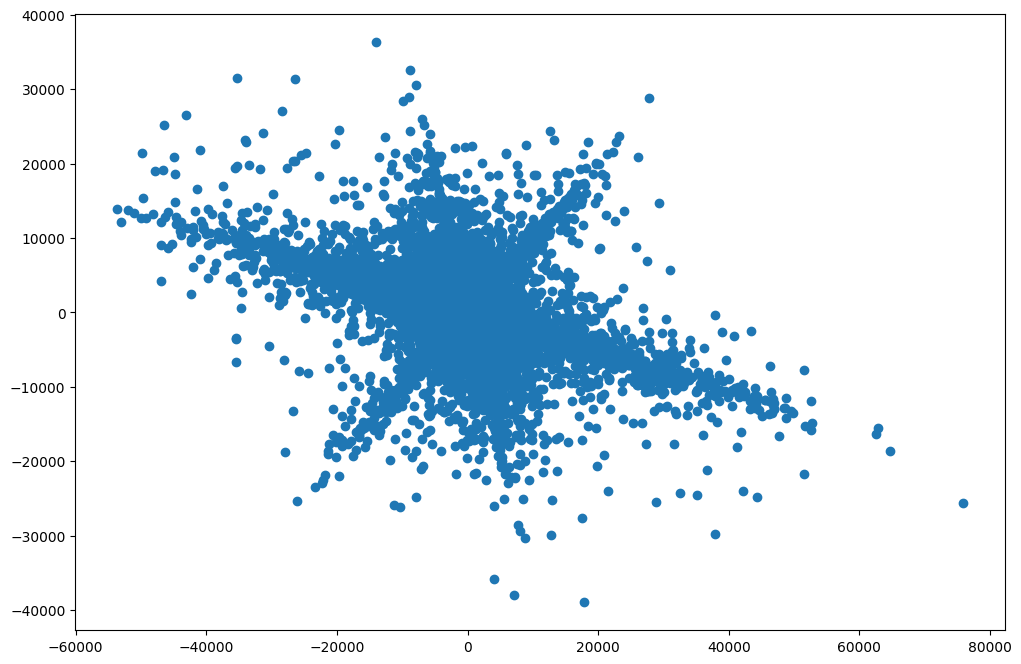

In [10]:
fig = plt.figure(figsize=(12,8))
plt.scatter(X[...,0], X[...,1])
plt.show()

3 directions.

5. Plot the histogram of the arguments of the points of aﬃx Z(f, n) for all f and n (you can use the Matlab function atan or the Python function numpy.arctan to compute the arguments modulo π, between − 2 π and + π , and the Matlab function hist or the Python function matplotlib.pyplot.hist 2 to compute the histogram, whose number of classes has to be tuned so as to make the directions of the sources clearly visible). Estimate the angles θ(k) (you can determine these values graphically from the histogram).

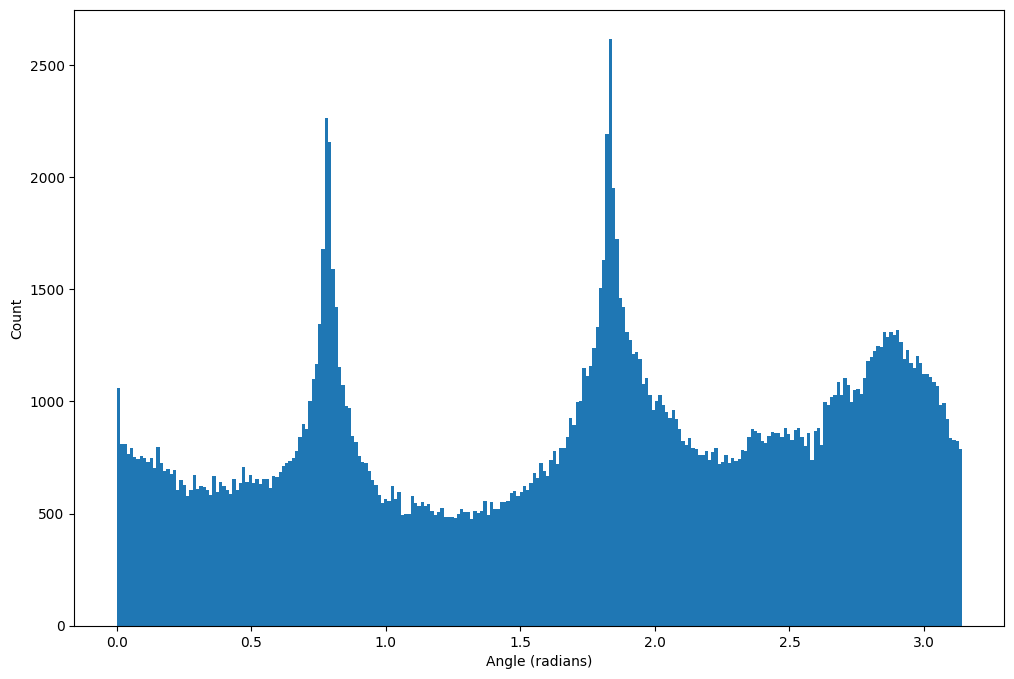

In [11]:
Z = X[...,0] + 1j*X[...,1]
angle = np.angle(Z.flatten()) % np.pi

fig = plt.figure(figsize=(12,8))
plt.hist(angle, bins=256)
plt.xlabel('Angle (radians)')
plt.ylabel('Count')
plt.show()

3 peaks, 0.8, 1.9, 2.9

6. In order to estimate the active source at every time-frequency bin (f, n), you can look for the source k whose angle θ(k) is closest to the argument of Z(f, n), modulo π (you can use a deviation measure invariant modulo π, for instance | sin (θ(k) − ∠Z(f, n)) |). Then generate the binary masks B ∈ {0, 1}, such that B(f, n, k) is equal to 1 if source k is active at (f, n), or 0 otherwise.

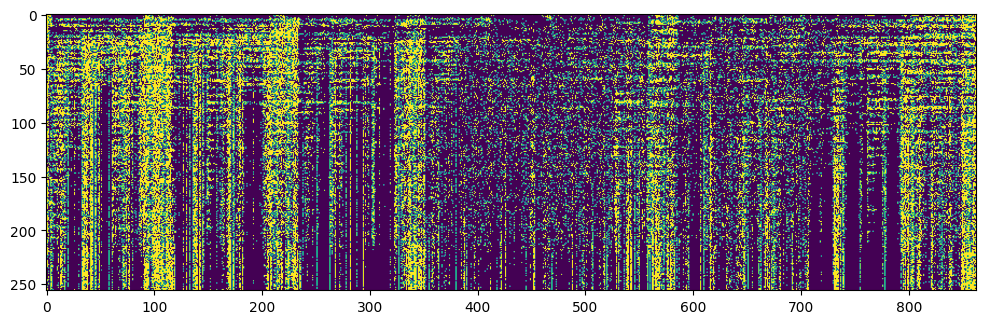

In [12]:
theta = np.linspace(-np.pi / 2, np.pi / 2, num=3)
B = np.zeros((Z.shape[0], Z.shape[1], len(theta)))
for f in range(Z.shape[0]):
    for n in range(Z.shape[1]):
        deviations = np.abs(np.sin(theta - np.angle(Z[f, n])))
        k_min = np.argmin(deviations)
        B[f, n, k_min] = 1

plt.imshow(B[...,0])
plt.show()

7. Apply masks B to the MDCT X(f, n, m) in order to estimate the MDCT of the stereophonic images Y(f, n, m, k). Then reconstruct the images y(t, m, k) of the source signals by applying the inverse MDCT (you can use the Matlab function iwmdct or the Python function imdct).

In [14]:
B_ext = np.expand_dims(B, axis=2)
B_ext = np.repeat(B_ext, 2, axis=2)
f, n = Z.shape
Y = np.zeros((f, n, 2, 3))

mask0 = B_ext[..., 0]
mask1 = B_ext[..., 1]
mask2 = B_ext[..., 2]
Y[:, :, :, 0] = mask0 * X
Y[:, :, :, 1] = mask1 * X
Y[:, :, :, 2] = mask2 * X
print(Y.shape)
y0 = imdct(Y[..., 0])
y1 = imdct(Y[..., 1])
y2 = imdct(Y[..., 2])

(256, 863, 2, 3)


ValueError: operands could not be broadcast together with shapes (512,) (1024,) 